# TIME SERIES FORECASTING DENGAN REAL DATASET

Mengimpor Library dan Memeriksa Versi Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


Membuat Fungsi Grafik Data Series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Waktu")
    plt.ylabel("Nilai")
    plt.grid(True)

Menghubungkan dengan Google Drive

In [ ]:
from google.colab import drive #Mengimpor G-Drive

drive.mount('/content/drive') #Mengatur lokasi Drive

Mounted at /content/drive


Mengakses Dataset

In [ ]:
import pandas as pd #Mengimpor Library Pandas

#Membaca File Dataset CSV
Dataset = pd.read_csv('/content/drive/MyDrive/Dataset/Sunspots.csv')
#Melihat Info Dataset
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3235 non-null   int64  
 1   Date                               3235 non-null   object 
 2   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 75.9+ KB


In [ ]:
#Melihat Isi Dataset
Dataset.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


Membuka Dataset

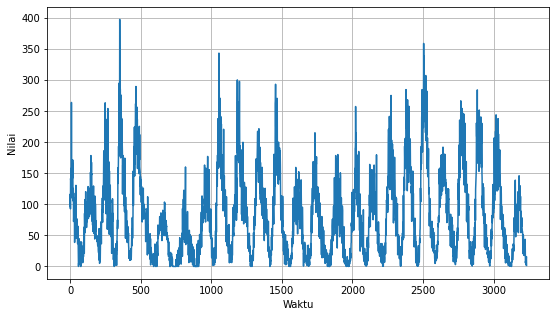

In [ ]:
import csv  #Mengimpor CSV
time_step = []
sunspot = []

#Membuka File CSV
with open('/content/drive/MyDrive/Dataset/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspot.append(float(row[2]))
    time_step.append(int(row[0]))

#Membuat Visualisasi Dataset
series = np.array(sunspot)
time = np.array(time_step)
plt.figure(figsize=(9, 5))
plot_series(time, series)

Membagi Dataset

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

Membuat Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    return dataset.batch(batch_size).prefetch(1)

Membuat Fungsi Untuk Memprediksi Model

In [ ]:
def prediksi_model(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    prediksi = model.predict(dataset)
    return prediksi

Membuat Model

In [ ]:
#Membersihkan Variabel luar
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64 #Mengatur Ukuran Window
batch_size = 256 #Mengatur Ukuran Batch

#Memanggil Windowed Dataset
train_set = windowed_dataset(x_train, window_size, batch_size,
                             shuffle_buffer_size)

print(train_set) #Melihat shape train_set
print(x_train.shape) #Melihat shape x_train

#Membuat Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), #Membuat Layer CNN
  tf.keras.layers.LSTM(64, return_sequences=True), #Membuat Layer lstm
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"), #Membuat Dense Layer
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400) #Membuat Lambda Layer
])

#Membuat Callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

#Mengcompile Model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [ ]:
model.summary() #Melihat Summary Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

Mentraining Model

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 11s 438ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 5s 363ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 5s 351ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 4s 336ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 4s 340ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 4s 344ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 4s 348ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 4s 347ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 4s 347ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [==============================] - 4s 345ms/step - loss: 52.3436 - mae: 52.8399
Epoch 11/100
12/12

Visualisasi Hasil Prediksi

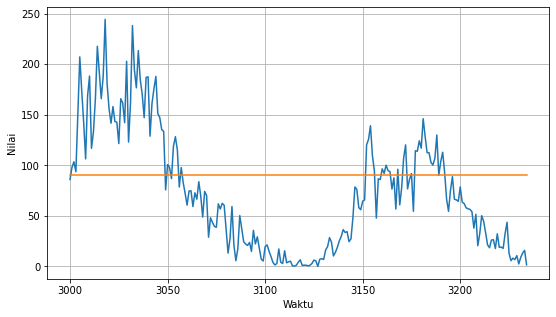

In [ ]:
prediksi_rnn = prediksi_model(model, series[..., np.newaxis], window_size)
prediksi_rnn = prediksi_rnn[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(9, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, prediksi_rnn)

Mengukur MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, prediksi_rnn).numpy()

52.40565

# Memperbaiki Model

Mencari Nilai Optimum

(1e-08, 0.0001, 0.0, 60.0)

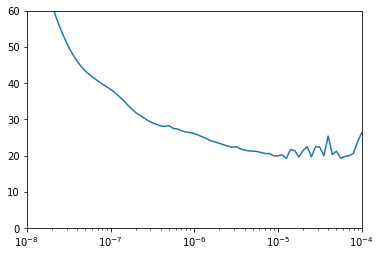

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Membuat Model Baru

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, 
                             shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Mentraining Model

In [ ]:
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 8s 134ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 131ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 4s 132ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 4s 133ms/step - loss: 20.4606 - mae: 20.9535
Epoch 5/500
30/30 [==============================] - 4s 131ms/step - loss: 19.7099 - mae: 20.2024
Epoch 6/500
30/30 [==============================] - 4s 133ms/step - loss: 19.3147 - mae: 19.8068
Epoch 7/500
30/30 [==============================] - 4s 133ms/step - loss: 18.7048 - mae: 19.1970
Epoch 8/500
30/30 [==============================] - 4s 134ms/step - loss: 18.1249 - mae: 18.6166
Epoch 9/500
30/30 [==============================] - 4s 132ms/step - loss: 18.0666 - mae: 18.5581
Epoch 10/500
30/30 [==============================] - 4s 133ms/step - loss: 17.9098 - mae: 18.4011
Epoch 11/500
30/30 

Visualisasi Hasil Prediksi

In [ ]:
rnn_baru = prediksi_model(model, series[..., np.newaxis], window_size)
rnn_baru = rnn_baru[split_time - window_size:-1, -1, 0]

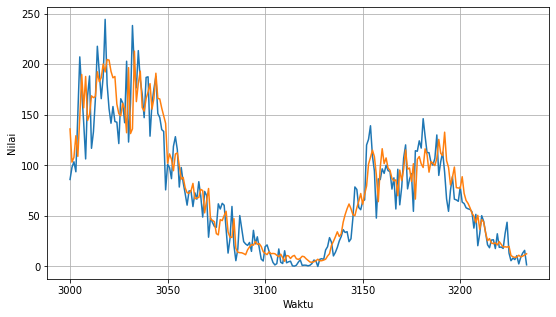

In [ ]:
plt.figure(figsize=(9, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_baru)

Mengukur MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_baru).numpy()

15.620486

Visualisasi Grafik Training Loss

<Figure size 432x288 with 0 Axes>

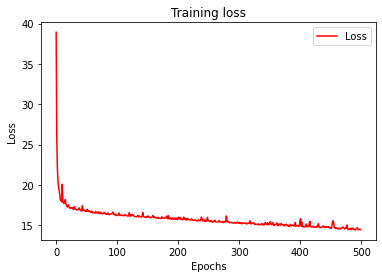

<Figure size 432x288 with 0 Axes>

In [ ]:
#impor library matplotlib
import matplotlib.image  as mpimg 
import matplotlib.pyplot as plt

loss=history.history['loss'] #mengambil data loss
epochs=range(len(loss))  #Menghitung jumlah epoch

#Membuat visualisasi grafik loss
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

Visualisasi Grafik Training Loss lebih Detail

<Figure size 432x288 with 0 Axes>

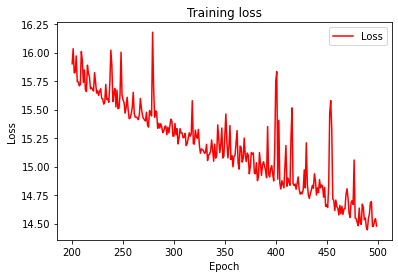

<Figure size 432x288 with 0 Axes>

In [ ]:
zoom_loss = loss[200:] #Mengambil data dari 200
zoom_epoch = range(200,500) #Range data dari 200 sampai 500

#Memvisualisasikan grafik
plt.plot(zoom_epoch, zoom_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

Hasil Prediksi RNN

In [ ]:
print(rnn_baru)

[135.93948   103.12235   107.854065  129.22385   108.84819   147.39487
 189.78087   156.79062   187.81398   144.31122   150.0124    168.67754
 166.9058    167.96768   192.48328   182.7197    186.66794   200.11948
 192.28748   204.5711    203.98186   192.89357   186.52187   187.82918
 160.57487   151.08842   148.91212   161.18733   156.05412   132.18439
 196.56184   131.38205   136.06392   212.91818   162.95776   181.05084
 193.0767    157.0092    153.59818   165.92699   172.63889   180.77162
 155.54376   166.10939   191.04233   166.12889   165.59535   156.55511
 148.85011   141.43314   102.08545   111.27063   106.03841    94.656075
 111.22477   112.19361    99.72339    86.33762    87.99869    77.85541
  72.827484   72.42288    74.6223     82.11267    66.877884   67.77999
  68.20702    76.20557    75.08509    52.962357   64.73747    77.068375
  46.685688   45.63053    44.194557   32.430347   31.180859   46.316635
  45.280518   50.386272   54.557896   34.109955   28.836811   28.727839
  